In [9]:
import pandas as pd
from IPython.display import Image, display
from pgmpy.estimators import ExhaustiveSearch
from pgmpy.estimators import K2Score
from pgmpy.models import BayesianNetwork
from pgmpy.base import DAG
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import ParameterEstimator
from sklearn.metrics import classification_report
from pgmpy.estimators import HillClimbSearch, K2Score, BDeuScore, BicScore, AICScore
from imblearn.over_sampling import BorderlineSMOTE
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('cardiovascular_train.csv')

print(df.columns)

Index(['Age', 'Anxiety', 'BodyMassIndex', 'Depression', 'Diabetes',
       'EducationLevel', 'Hypercholesterolemia', 'Hypertension',
       'PhysicalActivity', 'Sex', 'SleepDuration', 'SmokerProfile',
       'SocioeconomicStatus'],
      dtype='object')


# Structure Learning 

For and effective modeling of a Bayesian Network of CVD, the structure needs to be learned first before estimating the parameters of the network.
This step is crucial to determine which variables are directly connected, indicating the influence and the relationship between variables.

  0%|          | 0/1000000 [00:00<?, ?it/s]

Amount of connections between variables: 48


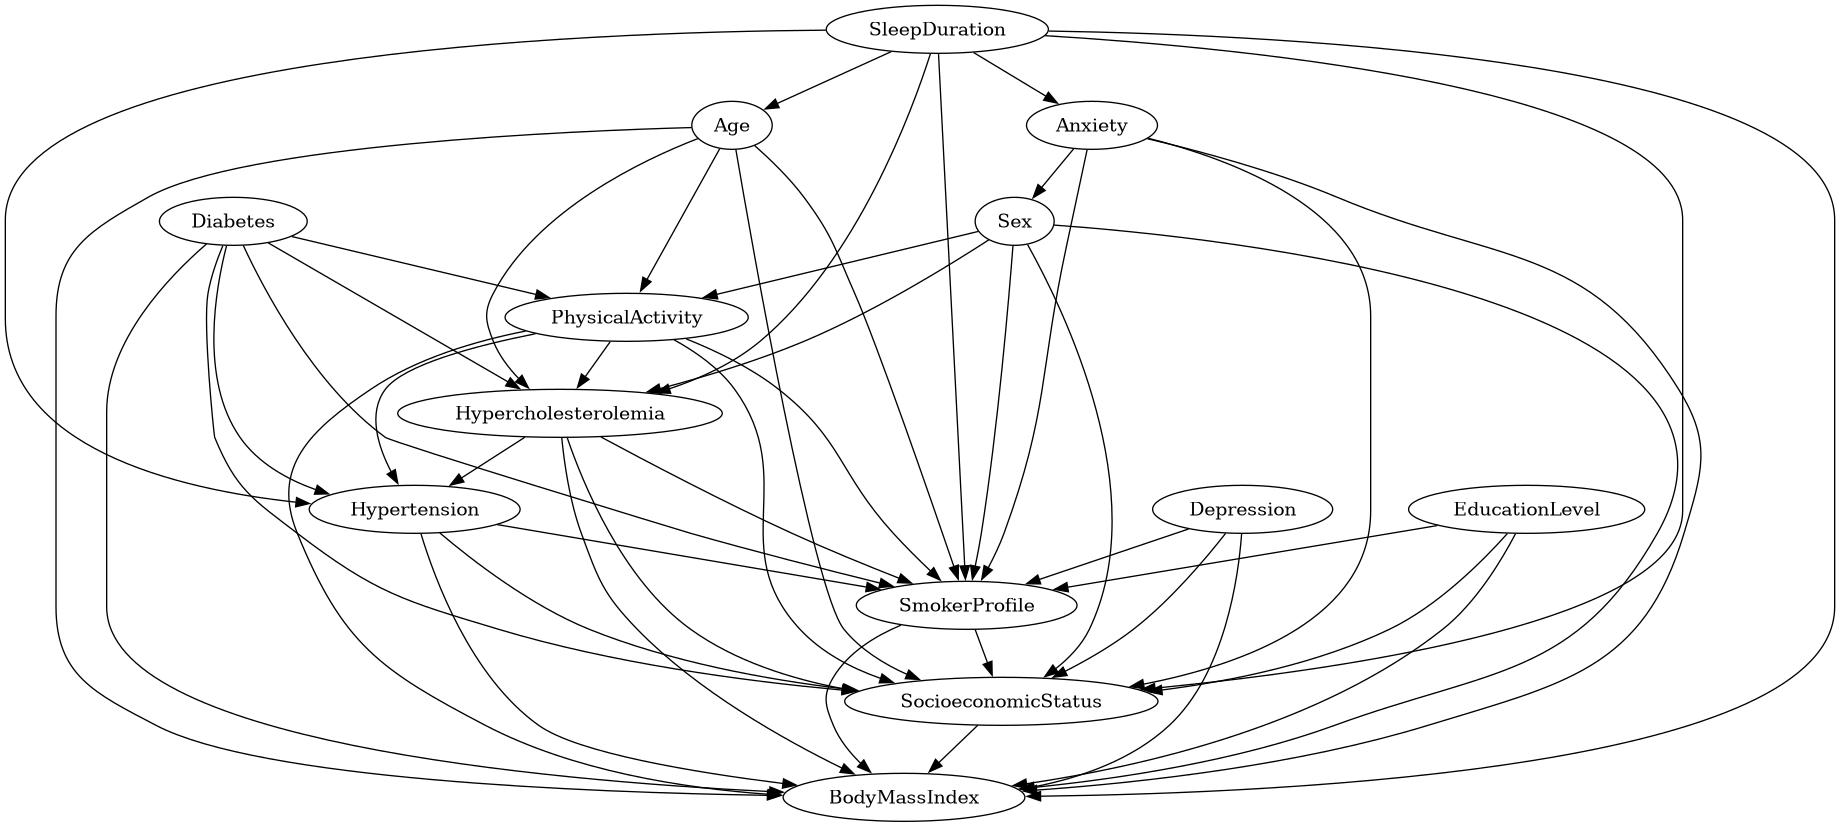

In [3]:
k2 = K2Score(df)
es = HillClimbSearch(data=df)
best_model = es.estimate(scoring_method=k2)
print('Amount of connections between variables:', len(best_model.edges()))
m = best_model.to_graphviz()
img = m.draw(format='png',prog="dot")
display(Image(img))

But trying to learn the structure without implementing some restrictions results in complex network with unecessary connections, that dificults the interpretation of the model.

### Restrictions 

To address this complexety, some restrictions are introduced in form of whitelists (connections that are mandatory) and blacklists (connections that are forbidden).
Theese restrictions, based on some common domain knoledge about what the relationships are likely to be and what variables influence each other, remove some unlikely and redundant connections that were going to complicate the network.

### Forbidden Connections

To maintain interpretability and avoid redundancy, the following connections are blacklisted:

- **Education Level → Hypercholesterolemia**: Education might influence the individual lifestyle but does not have a direct relationship with cholesterol levels.

- **EducationLevel → SleepDuration**:Education level does not have a direct effect on sleep duration. 

- **SleepDuration → SmokerProfile**:Smoking could impact sleep quality, but sleep duration does not determine smoking behavior.

- **Diabetes → PhysicalActivity**: Diabetes can limit physical activity if it leads to health complications, but it does not cause a reduction in physical activity directly.

### Independent Variables

Age and Sex are inherent features of the individual analysis, making them "root" nodes as they are not dependent on any factor in the model for demographic traits.

Similarly, Education Level and Socioeconomic Status are driven by broader societal factors rather than individual health or lifestyle behaviors. They, too, can then be seen as independent variables in this model. While these root variables are independent themselves, they may also have an effect on other variables.

### Approach Explanation

Based on the structure of the given problem, we found it best to designate **Age, Sex, Education Level, and Socioeconomic Status** as independent/root nodes, as these are inherent or social in nature.

We also emphasize a certain structural flow, especially for relationships concerning **diseases**. Interactions with diseases should flow in one direction,from lifestyle and behavioral factors to diseases, but not vice versa. In this model, we allow diseases (Diabetes, Hypertension, and Hypercholesterolemia) to influence each other because some health conditions increase the risk of others; for instance, Diabetes might increase the risk for Hypertension. However, we prevent diseases from influencing non-disease variables, as while lifestyle choices can affect the likelihood of developing health conditions, diseases themselves do not drive people to adopt certain behaviors.

By focusing mainly on **blacklisting** rather than **whitelisting**, we allow the model to be data-driven and avoid over-imposing assumptions. This approach retains interpretability by reducing model **complexity** and preserving **flexibility**, allowing for **data-driven** discovery while aligning with realistic known relationships.


In [4]:
def initialize_graph(nodes, p=1,blacklist=None):
    G = DAG()
    G.add_nodes_from(nodes)

    init = G.get_random(n_nodes=len(nodes), edge_prob=p)
    ls = []
    mapping = {k: nodes[k] for k in range(len(nodes))}

    for i, j in init.edges:
        mapped_edge = (mapping[i], mapping[j])

        if blacklist and mapped_edge in blacklist:
            continue

        ls.append(mapped_edge)

    G.add_edges_from(ls)

    return G

blacklist = [
    ("EducationLevel", "Hypercholesterolemia"), 
    ("EducationLevel", "SleepDuration"),         
    ("SleepDuration", "SmokerProfile"),                          
    ("Diabetes", "PhysicalActivity")             
]

exclude_nodes = ["Diabetes", "Hypertension", "Hypercholesterolemia"]

for col in df.columns:
    for target in df.columns:
        if col != target:  
            if col in exclude_nodes and target not in exclude_nodes:
                blacklist.append((col, target))

no_incoming = ["Age", "Sex", "EducationLevel", "SocioeconomicStatus"]

for col in df.columns:
    for target in no_incoming:
        if col != target:
            blacklist.append((col, target))

## Choosing the best model

When building a Bayesian network choosing the optimal structure is has important has making the right restrictions. In this code the choice of model is based on the scoring metric and the complexity of the model.

The code bellow aims to get the score of each score method and generating a model using the Hill Climb Search algorithm. 

  0%|          | 0/1000000 [00:00<?, ?it/s]

K2 score: -18517.1430505307


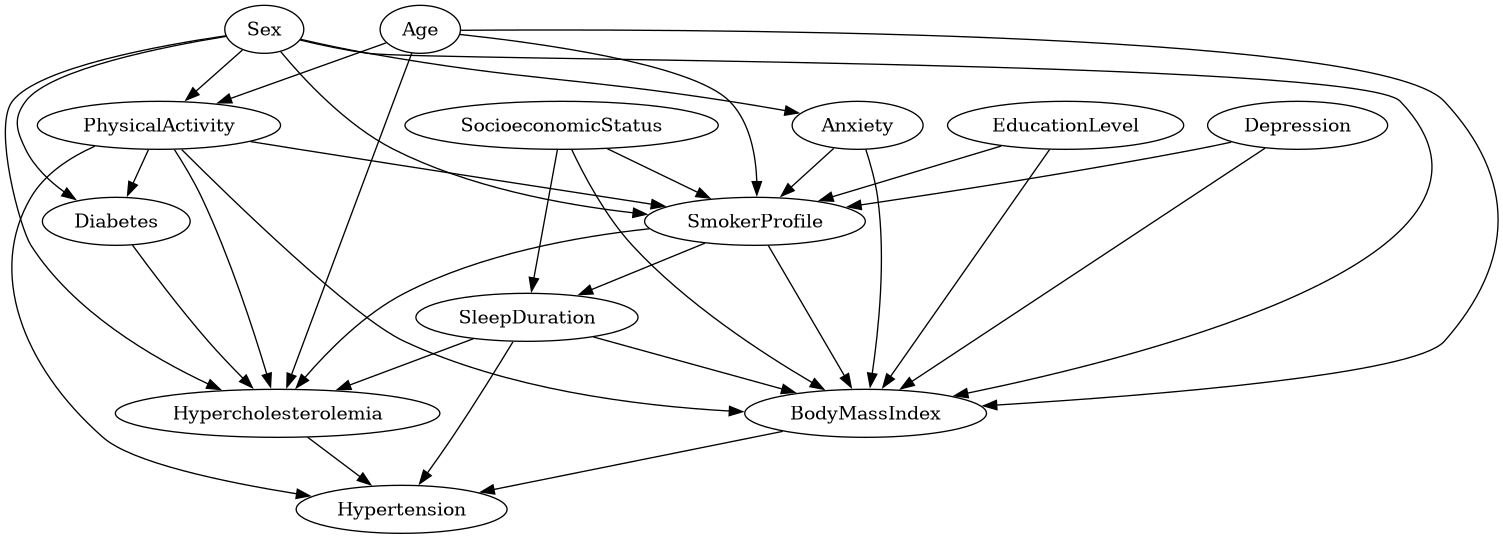


Model structure for K2:

Number of edges 33


  0%|          | 0/1000000 [00:00<?, ?it/s]

BDeu score: -32120.754921472402


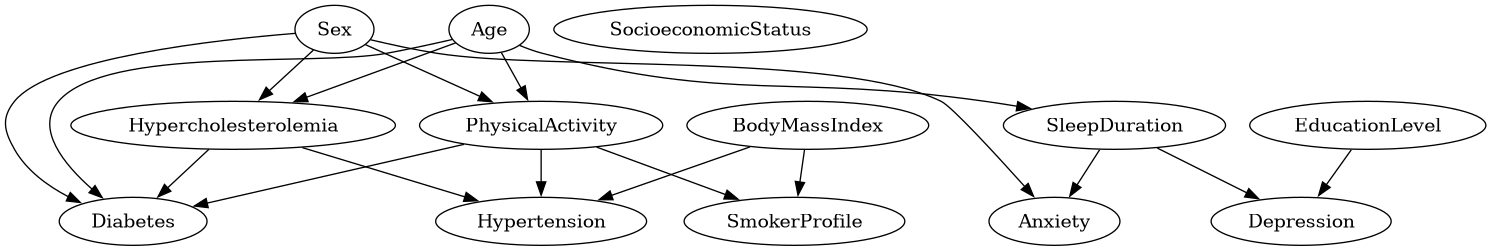


Model structure for BDeu:

Number of edges 18


  0%|          | 0/1000000 [00:00<?, ?it/s]

BIC score: -31887.01573959794


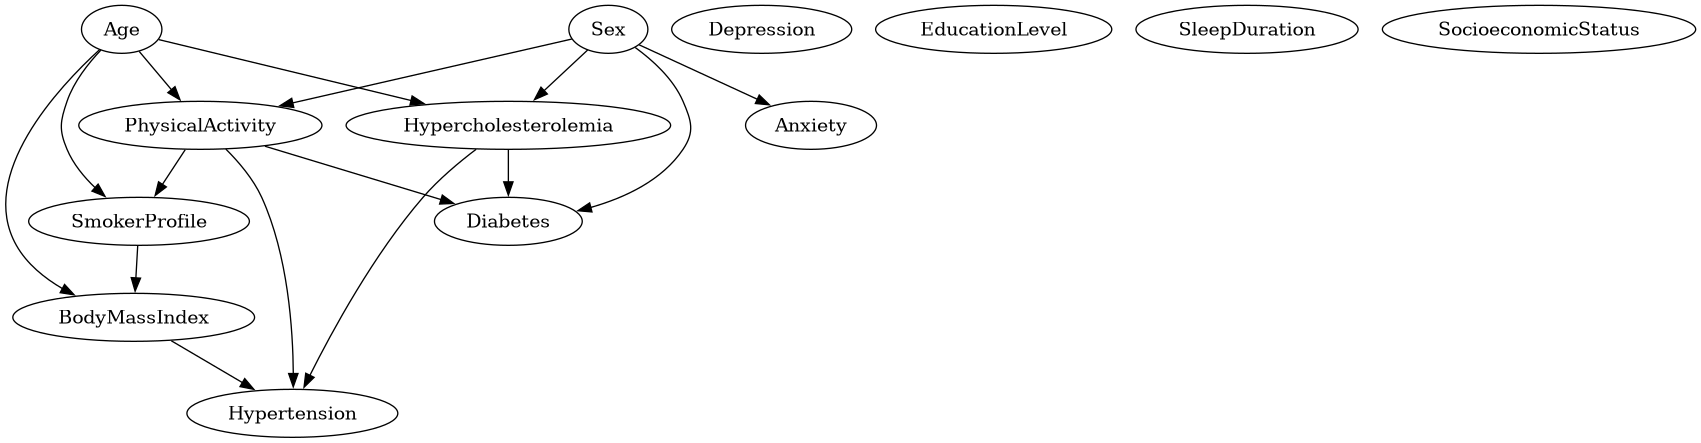


Model structure for BIC:

Number of edges 15


  0%|          | 0/1000000 [00:00<?, ?it/s]

AIC score: -31100.82098512779


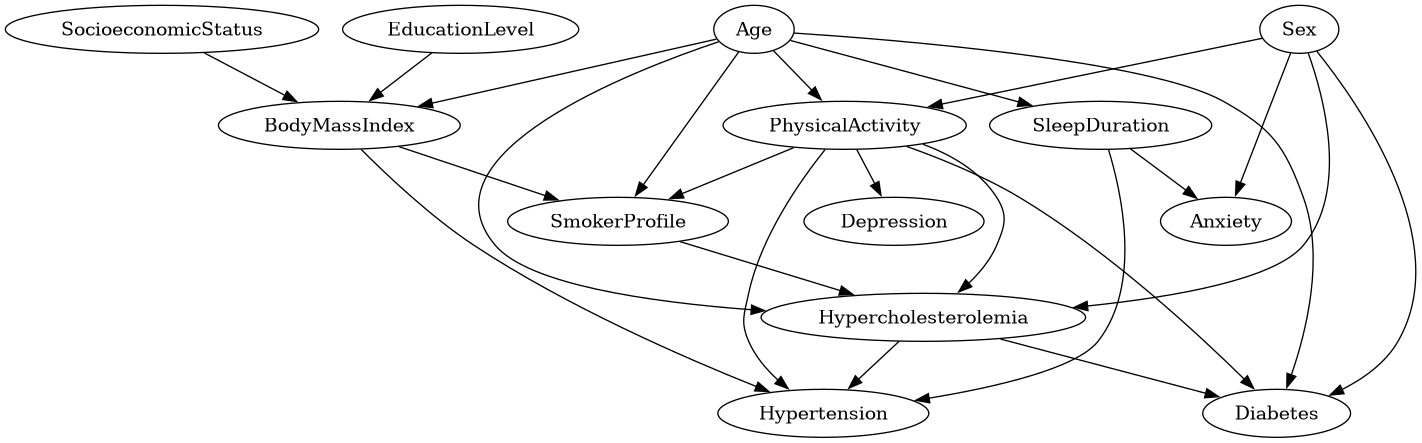


Model structure for AIC:

Number of edges 24


In [5]:
# Load the dataset
df = pd.read_csv('cardiovascular_train.csv')
es = HillClimbSearch(data=df)
start_dag = initialize_graph(nodes=df.keys(), p=1, blacklist=blacklist)

scoring_methods = {
    "K2": K2Score(df),
    "BDeu": BDeuScore(df),
    "BIC": BicScore(df),
    "AIC": AICScore(df)
}
models = []

es = HillClimbSearch(data=df)

for name, score_method in scoring_methods.items():
    model = es.estimate(
        scoring_method=score_method,
        start_dag=start_dag,
        black_list=blacklist
    )
    models.append(model)
    score = score_method.score(model)
    print(f"{name} score: {score}")

    m = model.to_graphviz()
    img = m.draw(format='png', prog="dot")
    display(Image(img))
    
    print(f"\nModel structure for {name}:\n")
    print("Number of edges",len(model.edges()))

# Classification of the three medical conditions

In [6]:
warnings.filterwarnings("ignore", message="invalid value encountered in divide")

BNmodel = BayesianNetwork(models[3].edges())
BNmodel.fit(df, estimator=MaximumLikelihoodEstimator)

test = pd.read_csv('cardiovascular_test.csv')

target_conditions = ["Diabetes", "Hypertension", "Hypercholesterolemia"]

for condition in target_conditions:
    print(f"Evaluating model for {condition}...")

    y_test = test[condition]
    x_test = test.drop(columns=[condition])

    predictions = BNmodel.predict(x_test)

    print(f"Classification report for {condition}:")
    print(classification_report(y_test, predictions[condition]))
    print("\n" + "-"*50 + "\n")

Evaluating model for Diabetes...


  0%|          | 0/808 [00:00<?, ?it/s]

Classification report for Diabetes:
              precision    recall  f1-score   support

          No       0.95      1.00      0.98      1224
         Yes       0.00      0.00      0.00        58

    accuracy                           0.95      1282
   macro avg       0.48      0.50      0.49      1282
weighted avg       0.91      0.95      0.93      1282


--------------------------------------------------

Evaluating model for Hypertension...


  0%|          | 0/741 [00:00<?, ?it/s]

Classification report for Hypertension:
              precision    recall  f1-score   support

          No       0.85      0.98      0.91      1052
         Yes       0.64      0.19      0.29       230

    accuracy                           0.84      1282
   macro avg       0.74      0.58      0.60      1282
weighted avg       0.81      0.84      0.80      1282


--------------------------------------------------

Evaluating model for Hypercholesterolemia...


  0%|          | 0/704 [00:00<?, ?it/s]

/home/hugodnf/Documents/jupyter-workspace/AAA/lib/python3.12/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


Classification report for Hypercholesterolemia:
              precision    recall  f1-score   support

          No       0.71      0.88      0.78       795
         Yes       0.67      0.41      0.51       487

    accuracy                           0.70      1282
   macro avg       0.69      0.64      0.64      1282
weighted avg       0.69      0.70      0.68      1282


--------------------------------------------------



## Observations

Observing the cclassification reports, the model shows a good performace on predicting the "No" class in each disease, but reveals a lower score in accurately classifying the "Yes" class in each disease.

#### Diabetes

The model shows a very low recal for the the "Yes" class, meaning that the model rarely identifies positive cases of diabetes, due to the imbalance in the dataset, where "Yes" cases are much fewer then "No" cases. It is also observed a high precision meaning the when the model predicts a "Yes" class its confident on its prediction and its always correct.

#### Hypertensions

In the case of Hypertension although the model show a better balance in both classes, it show a low recall for the "Yes" class, suggesting that the model, when predicting the class it fails to identify a lot of positive cases.

#### Hypercholesterolemia

In the case of Hypercholesterolemia, the model shows the better performance but still with a moderate performace for the "Yes" when comparing with the "No". 

# Imporving Classification Results

In [7]:
conditions = ["Diabetes", "Hypertension", "Hypercholesterolemia"]
for condition in conditions:
    print(condition)
    no_count = df[condition].value_counts().get('No', 0)
    yes_count = df[condition].value_counts().get('Yes', 0)
    print(f"Number of 'No' class cases in train: {no_count}")
    print(f"Number of 'Yes' class cases in train: {yes_count}")
    print("-" * 30)  

Diabetes
Number of 'No' class cases in train: 3669
Number of 'Yes' class cases in train: 176
------------------------------
Hypertension
Number of 'No' class cases in train: 3107
Number of 'Yes' class cases in train: 738
------------------------------
Hypercholesterolemia
Number of 'No' class cases in train: 2351
Number of 'Yes' class cases in train: 1494
------------------------------


The clear imbalance between classes in now better observed, and has mentioned earlier and expected, Diabetes being the disease with the bigger discrepancy in classes its also the one with the worse scores. A better balance, shows however better scores.

#### SMOTE

To first implemente the SMOTE algorithm we need to first map all the values to numerical values.

In [17]:
df_numeric = pd.read_csv('cardiovascular_train.csv')

mappings = {
    'Sex': {'Female': 0, 'Male': 1},
    'Age': {'18-24':0, '24-34': 1, '34-44': 2, '44-54': 3, '54-64': 4, '64-74': 5},
    'EducationLevel': {1: 0, 2: 1, 3: 2},
    'SocioeconomicStatus': {1: 0, 2: 1, 3.0: 2},
    'BodyMassIndex': {'Underweight': 0, 'Normal': 1, 'Obese': 2, 'Overweight': 3},
    'PhysicalActivity': {'Insufficiently Active': 0, 'Regularly Active': 1},
    'SleepDuration': {'<6hours': 0, '6-9hours': 1, '>9hours': 2},
    'SmokerProfile': {'Non_Smoker': 0, 'Ex_Smoker': 1, 'Smoker': 2},
    'Anxiety': {'Yes': 1, 'No': 0},
    'Depression': {'Yes': 1, 'No': 0},
    'Hypertension': {'Yes': 1, 'No': 0},
    'Hypercholesterolemia': {'Yes': 1, 'No': 0},
    'Diabetes': {'Yes': 1, 'No': 0},
}

df_numeric.replace(mappings, inplace=True)
df_numeric.to_csv('cardiovascular_train_numeric.csv', index=False)
print("DataFrame saved to 'cardiovascular_train_numeric.csv'")

DataFrame saved to 'cardiovascular_train_numeric.csv'


In [18]:
from imblearn.over_sampling import BorderlineSMOTE

df_numeric = pd.read_csv('cardiovascular_train_numeric.csv')

X = df_numeric.drop(columns=['Diabetes'])  
y = df_numeric['Diabetes']                

smote_1 = BorderlineSMOTE(kind='borderline-1', random_state=42)
X_resampled_1, y_resampled_1 = smote_1.fit_resample(X, y)

df_borderline_smote_1 = pd.concat([pd.DataFrame(X_resampled_1, columns=X.columns), pd.DataFrame(y_resampled_1, columns=['Diabetes'])], axis=1)

df_borderline_smote_1.to_csv('cardiovascular_train_borderline_smote.csv', index=False)

print("Resampled datasets with borderline")

Resampled datasets with borderline


In [ ]:
df_smote_numeric = pd.read_csv('cardiovascular_train_borderline_smote.csv')

inverse_mappings = {col: {v: k for k, v in mapping.items()} for col, mapping in mappings.items()}

df_smote_numeric.replace(inverse_mappings, inplace=True)
df_smote_numeric.to_csv('cardiovascular_train_borderline_smote.csv', index=False)
print("DataFrame saved to 'cardiovascular_train_numeric.csv'")

In [19]:
BNmodel = BayesianNetwork(models[3].edges())
BNmodel.fit(df, estimator=MaximumLikelihoodEstimator)

import pandas as pd
from sklearn.metrics import classification_report

# Assuming BNmodel is already defined and fitted
print("Using Borderline SMOTE")
print(f"Evaluating model for Diabetes...")

test_1 = pd.read_csv('cardiovascular_train_borderline_smote.csv')
y_test_1 = test_1["Diabetes"]
x_test_1 = test_1.drop(columns=["Diabetes"])

predictions_1 = BNmodel.predict(x_test_1)

print(f"Classification report for Diabetes (Borderline 1 SMOTE):")
print(classification_report(y_test_1, predictions_1["Diabetes"]))

Using Borderline SMOTE
Evaluating model for Diabetes...


  0%|          | 0/1813 [00:00<?, ?it/s]

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

switch to using all state names as state numbers


Classification report for Diabetes (Borderline 1 SMOTE):



KeyboardInterrupt





Certain connections are strongly supported by research and science and should be mandatory edges in the network. These connections represent a relationship that significantly contributes to CVD risk, such as:

- **Age → Hypertension**: Blood pressure in most cases increases with age due to arterial stiffening, making it most common in older individuals.

- **Age → Hypercholesterolomia**: Cholesterol levels also rise has age increases.

-  **BodyMassIndex → Hypertension**: A Higher BMI, and more specific an obese condition places more stress in the hearth and blood vessels, resulting in a elevated blood pressure.

-  **Anxiety → Hypertension**: Anxiety can lead to a more increased blood pressure due to a more active nervous system and stress hormones.

-  **PhysicalActivity → BodyMassIndex**: Regular physical activity is associated with a lower BMI.

-  **Diabetes → Hypertension**: Diabetes damages blood vessels increasing the risk of developing hypertension.

-  **Depression → PhysicalActivity**: Depression in general cases can influence the ammount of physical activities individuals practice.